In [1]:
# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    USING_COLAB = True
except:
    USING_COLAB = False

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from datasets import load_dataset
import glob
import json
import os
import time
from datetime import datetime

In [3]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from functools import partial

In [4]:
import spacy
import nltk
from nltk.corpus import stopwords
import string
import threading

In [5]:
# # # COLAB
# nltk.download('stopwords')

In [6]:
# # # COLAB
# !python -m spacy download en_core_web_lg

In [7]:
pd.set_option('display.max_columns', None)

In [ ]:
if USING_COLAB:
    path_dataset_target = "/content/drive/My Drive/GTSI/Codigos_investigadores/supervised_new_data/dataset/target"
    path_dataset = "/content/drive/My Drive/GTSI/Codigos_investigadores/supervised_new_data/dataset"
    completed_path_save = "/colab_union"
else:
    path_dataset_target = "./dataset/target"
    path_dataset = "./dataset"
    completed_path_save = "/local_union"

##### Text

In [9]:
# df = pd.read_csv(path_dataset + "/patentes_target.csv")

In [10]:
# df.keys()

In [11]:
# df["text"] = df["title"].str.lower() + " " + df["abstract"].str.lower()

In [12]:
# # replace spaces with a single space
# # eliminamos numeros y caracteres especiales
# # numeros no relevantes como fechas, codigos, referencias, etc.
# # enforcarnos en patrones lingüísticos, semanticos y terminológicos realmente relevantes
# df["text"] = df["text"].str.replace(r'\d+', '', regex=True)  # Remove numbers
# df["text"] = df["text"].str.replace(r'\W+', ' ', regex=True)  # Remove special characters
# df["text"] = df["text"].str.strip()  # Remove leading and trailing spaces
# df["text"] = df["text"].str.replace(r'\s+', ' ', regex=True)  # Replace multispaces with a single space
# # # remove duplicated rows
# df = df.drop_duplicates(subset=["text"], keep="first")

In [13]:
# df.shape

In [14]:
# df["decision"].value_counts() # shape 657932


In [15]:
# # df.drop(["title", "abstract"], axis=1)

In [16]:
# df.shape[0], df["title"].nunique(), df["abstract"].nunique(), df["text"].nunique()

In [17]:
# values_count = df["text"].value_counts()
# values_repeat = values_count[values_count > 1].keys()

In [18]:
# df["gpu_used"] = pd.NA
# df["batch_id"] = pd.NA

In [19]:
# df[~df["text"].isin(values_repeat)].to_csv(path_dataset + "/patentes_target_update.csv", index=False)

##### Funciones de lematizacion y filtrado de stopswords

In [20]:
# nlp = spacy.load("es_core_news_sm")
nlp = spacy.load("en_core_web_lg")

In [21]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stop_words = stopwords_es | stopwords_en

In [22]:
# Función de limpieza y lematización
def procesar_texto(texto):
    if pd.isna(texto):
        return ""
    # Unicode, minúsculas, quitar puntuación
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))
    # Procesar con spaCy
    doc = nlp(texto)
    # Lematizar y quitar stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and not token.is_space]
    # *************************************** REVISAR *****************************************
    # tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    # *****************************************************************************************

    return " ".join(tokens)

# Unir columnas y procesar
def crear_corpus(row):
    return procesar_texto(str(row['text']))

In [23]:
# OPCIÓN 1: Paralelización con ThreadPoolExecutor (más simple)
def procesar_corpus_paralelo_threads(df, num_threads=3):
    """
    Paraleliza el procesamiento usando ThreadPoolExecutor
    Mejor para I/O bound tasks
    """
    def procesar_batch(batch_df):
        """Procesa un batch de filas"""
        return batch_df.apply(crear_corpus, axis=1)
    
    # Dividir el DataFrame en batches
    batches = np.array_split(df, num_threads)
    
    print(f"Procesando {len(df)} filas en {num_threads} hilos...")
    print(f"Tamaños de batch: {[len(batch) for batch in batches]}")
    
    # Procesar en paralelo
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(procesar_batch, batches))
    
    # Concatenar resultados
    corpus_procesado = pd.concat(results, ignore_index=True)
    return corpus_procesado


# OPCIÓN 3: Híbrida - dividir por chunks y usar threads
def procesar_corpus_paralelo_chunks(df, num_threads=3, chunk_size=1000):
    """
    Divide el DataFrame en chunks y procesa cada chunk en paralelo
    Útil para DataFrames muy grandes
    """
    def procesar_chunk(chunk_data):
        chunk_df, chunk_idx = chunk_data
        
        # Obtener información del hilo actual
        thread_id = threading.current_thread().ident
        thread_name = threading.current_thread().name
        start_time = time.time()
        timestamp = datetime.now().strftime("%H:%M:%S.%f")[:-3]
        
        print(f"  [{timestamp}] 🚀 Chunk {chunk_idx:2d} ({len(chunk_df):4d} filas) -> {thread_name} (ID: {thread_id})")

        return chunk_df.apply(crear_corpus, axis=1)
    
    # Dividir en chunks
    chunks = []
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i+chunk_size]
        chunks.append((chunk, i//chunk_size))
    
    print(f"📊 Procesando {len(df)} filas en {len(chunks)} chunks usando {num_threads} hilos...")
    print(f"📦 Tamaños de chunks: {[len(chunk[0]) for chunk in chunks]}")

    start_total = time.time()
    
    # Procesar chunks en paralelo
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        print(f"\n🔄 Iniciando procesamiento paralelo...")
        results = list(executor.map(procesar_chunk, chunks))
        print(f"\n🎉 Procesados {len(results)} chunks")

    end_total = time.time()
    total_duration = end_total - start_total
    
    print(f"\n🎉 Todos los chunks procesados en {total_duration:.2f}s")

    # Concatenar resultados
    corpus_procesado = pd.concat(results, ignore_index=True)
    print(f"✅ Procesamiento completo. Total de filas procesadas: {len(corpus_procesado)}")
    return corpus_procesado

##### Carga de archivo

In [24]:
df_original = pd.read_csv(path_dataset + "/patentes_target_update.csv")

Ejecutor de CORPUS

In [ ]:
# df_original["CORPUS"] = df_original.apply(crear_corpus, axis=1)

# # Método 1: ThreadPoolExecutor
# print("\n1. Usando ThreadPoolExecutor:")
# df_original["CORPUS"] = procesar_corpus_paralelo_threads(df_original, num_threads=3)


# Método 2: Chunks con threads
print("\n2. Usando chunks con ThreadPoolExecutor:")
df_original["CORPUS"] = procesar_corpus_paralelo_chunks(df_original, num_threads=12, chunk_size=1000)

print("Shape del dataframe: ", df_original.shape[0])
# 1639m 45.7s


2. Usando chunks con ThreadPoolExecutor:
📊 Procesando 700083 filas en 701 chunks usando 12 hilos...
📦 Tamaños de chunks: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1

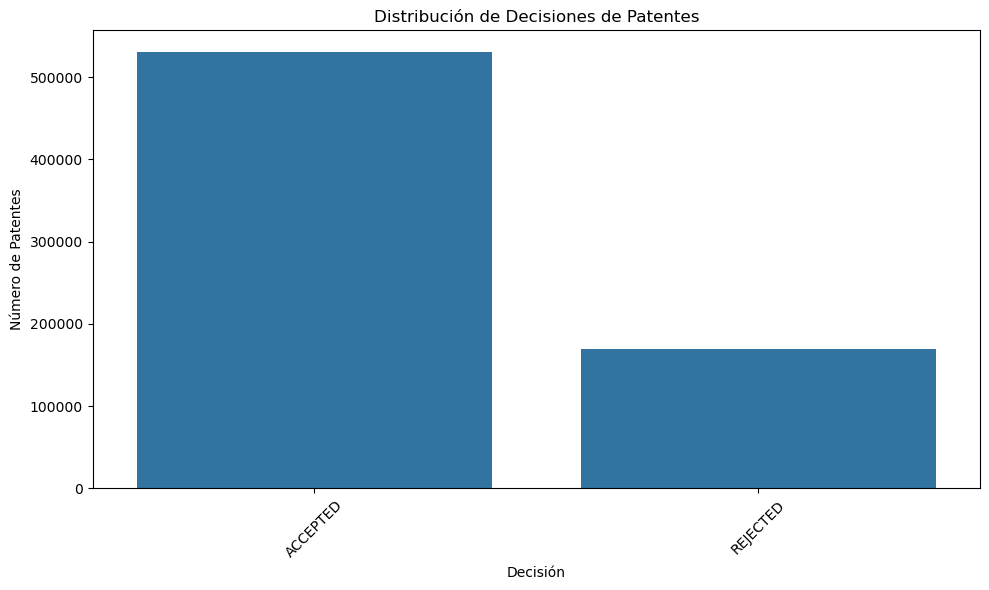

In [26]:
# diagrama de barras de la columna "decision"
plt.figure(figsize=(10, 6))
sns.countplot(data=df_original, x='decision', order=df_original['decision'].value_counts().index)
plt.title('Distribución de Decisiones de Patentes')
plt.xlabel('Decisión')
plt.ylabel('Número de Patentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_original.to_csv(path_dataset + completed_path_save + "/patentes_target_update_new.csv", index=False)

##### Union augmented

In [27]:
list_dfs = glob.glob(path_dataset_target + "/*")
df_new = df_original.copy()

In [ ]:
start_time_general = time.time()
for file in list_dfs:
    start_time = time.time()
    print("El archivo: ", file)
    print("Leyendo el archivo...")
    df = pd.read_csv(file)

    df["text"] = df["title"].str.lower() + " " + df["abstract"].str.lower()
    print("Shape del dataframe: ", df.shape[0])
    print("Primero count de valores: ", df["decision"].value_counts())

    print("-"*20)
    # Evitar los nulos de gpu_used y batch_id ya que son los mismo de original
    print("Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED")
    df = df[(~df["gpu_used"].isna()) & (~df["batch_id"].isna()) & (df["decision"] == "REJECTED")]

    print("Procesando la columna 'text'...")
    # replace spaces with a single space
    df["text"] = df["text"].str.replace(r'\d+', '', regex=True)  # Remove numbers
    df["text"] = df["text"].str.replace(r'\W+', ' ', regex=True)  # Remove special characters
    df["text"] = df["text"].str.strip()  # Remove leading and trailing spaces
    df["text"] = df["text"].str.replace(r'\s+', ' ', regex=True)  # Replace multispaces with a single space
    # remove duplicated rows
    print("Shape del dataframe despues de eliminar nulos y procesar: ", df.shape[0])
    df = df.drop_duplicates(subset=["text"], keep="first")

    print("Lematizando y filtrando stopwords...")
    df["CORPUS"] = df.apply(crear_corpus, axis=1)

    print("Shape del dataframe despues de eliminar duplicados y lematizar: ", df.shape[0])
    print("Nuevo count de valores: ", df["decision"].value_counts())

    print("-"*20)
    # Merge con el original
    print("Haciendo concat del original")
    df_new = pd.concat([df_new, df], ignore_index=True)
    print("Nuevo shape del dataframe: ", df_new.shape)
    print("Nuevo count de valores: ", df_new["decision"].value_counts())

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tiempo de procesamiento del archivo {file}: {(elapsed_time/ 60):.2f} minutos")
    print("*"*50)
end_time_general = time.time()
elapsed_time_general = end_time_general - start_time_general
print(f"Tiempo total de procesamiento: {(elapsed_time_general / 60):.2f} minutos")
# 12m 32.2s
# 162m 3.1s

El archivo:  ./dataset/target\patentes_target_balanced_0.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  760392
Primero count de valores:  decision
ACCEPTED    580769
REJECTED    179623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  1000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  1000
Nuevo count de valores:  decision
REJECTED    1000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (701083, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    170582
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_0.csv: 0.73 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_1.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  768392
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    188623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  10000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  10000
Nuevo count de valores:  decision
REJECTED    10000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (711083, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    180582
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_1.csv: 5.17 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_10.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  758892
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179123
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  500
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  500
Nuevo count de valores:  decision
REJECTED    500
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (711583, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    181082
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_10.csv: 0.41 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_11_kaggle.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  808535
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    228766
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  50143
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  50143
Nuevo count de valores:  decision
REJECTED    50143
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (761726, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    231225
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_11_kaggle.csv: 23.09 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_12.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  758892
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179123
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  500
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  500
Nuevo count de valores:  decision
REJECTED    500
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (762226, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    231725
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_12.csv: 0.38 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_13.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  759097
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179328
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  705
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  705
Nuevo count de valores:  decision
REJECTED    705
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (762931, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    232430
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_13.csv: 0.55 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_14_kaggle.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  778392
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    198623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  20000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  20000
Nuevo count de valores:  decision
REJECTED    20000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (782931, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    252430
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_14_kaggle.csv: 8.73 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_15_kaggle.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  770392
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    190623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  12000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  12000
Nuevo count de valores:  decision
REJECTED    12000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (794931, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    264430
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_15_kaggle.csv: 5.42 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_16.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  758892
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179123
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  500
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  500
Nuevo count de valores:  decision
REJECTED    500
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (795431, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    264930
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_16.csv: 0.39 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_2_kaggle.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  858678
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    278909
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  100286
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  100286
Nuevo count de valores:  decision
REJECTED    100286
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (895717, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    365216
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_2_kaggle.csv: 48.67 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_3.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  761392
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    181623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  3000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  3000
Nuevo count de valores:  decision
REJECTED    3000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (898717, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    368216
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_3.csv: 1.65 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_4.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  763392
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    183623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  5000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  5000
Nuevo count de valores:  decision
REJECTED    5000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (903717, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    373216
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_4.csv: 2.65 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_5.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  759392
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179623
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  1000
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  1000
Nuevo count de valores:  decision
REJECTED    1000
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (904717, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    374216
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_5.csv: 0.71 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_6.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  758892
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179123
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  500
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  500
Nuevo count de valores:  decision
REJECTED    500
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (905217, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    374716
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_6.csv: 0.60 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_7.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  758892
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179123
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  500
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  500
Nuevo count de valores:  decision
REJECTED    500
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (905717, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    375216
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_7.csv: 0.54 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_8_kaggle.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  858678
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    278909
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  100286
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  100286
Nuevo count de valores:  decision
REJECTED    100286
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (1006003, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    475502
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_8_kaggle.csv: 61.75 minutos
**************************************************
El archivo:  ./dataset/target\patentes_target_balanced_9.csv
Leyendo el archivo...


C:\Users\saraujo\AppData\Local\Temp\ipykernel_25076\65026498.py:6: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Shape del dataframe:  758892
Primero count de valores:  decision
ACCEPTED    579769
REJECTED    179123
Name: count, dtype: int64
--------------------
Eliminando los nulos de gpu_used y batch_id, descarte de REJECTED
Procesando la columna 'text'...
Shape del dataframe despues de eliminar nulos y procesar:  500
Lematizando y filtrando stopwords...
Shape del dataframe despues de eliminar duplicados y lematizar:  500
Nuevo count de valores:  decision
REJECTED    500
Name: count, dtype: int64
--------------------
Haciendo concat del original
Nuevo shape del dataframe:  (1006503, 9)
Nuevo count de valores:  decision
ACCEPTED    530501
REJECTED    476002
Name: count, dtype: int64
Tiempo de procesamiento del archivo ./dataset/target\patentes_target_balanced_9.csv: 0.61 minutos
**************************************************
Tiempo total de procesamiento: 162.05 minutos


In [29]:
df_new.shape[0], df_new["title"].nunique(), df_new["abstract"].nunique(), df_new["text"].nunique(), df_new.shape[0] == df_new["text"].nunique()

(1006503, 605981, 999061, 1006502, False)

In [30]:
df_new_cp = df_new.drop_duplicates(subset=["text"], keep="first")

In [31]:
df_new_cp.rename(columns={"decision": "value"}, inplace=True)

In [32]:
df_new_cp.shape[0], df_new_cp["title"].nunique(), df_new_cp["abstract"].nunique(), df_new_cp["text"].nunique(), df_new_cp.shape[0] == df_new_cp["text"].nunique()

(1006502, 605981, 999061, 1006502, True)

In [33]:
df_new_cp["value"].value_counts()

value
ACCEPTED    530501
REJECTED    476001
Name: count, dtype: int64

In [ ]:
df_new_cp.to_csv(path_dataset + completed_path_save + "/patentes_target_union_all.csv", index=False)

In [ ]:
# descartar "title" y "abstract" para guardar
df_new_cp_less = df_new_cp.copy()
df_new_cp_less = df_new_cp_less.drop(["title", "abstract"], axis=1) # 'aplication_number', 'publication_number'
df_new_cp_less.to_csv(path_dataset + completed_path_save + "/patentes_target_union.csv", index=False)

In [36]:
530501 - 474796

55705

In [37]:
493317 - 437329

55988

##### Analytic

In [38]:
# df_new_cp = pd.read_csv(path_dataset + "/patentes_target_union_all.csv")

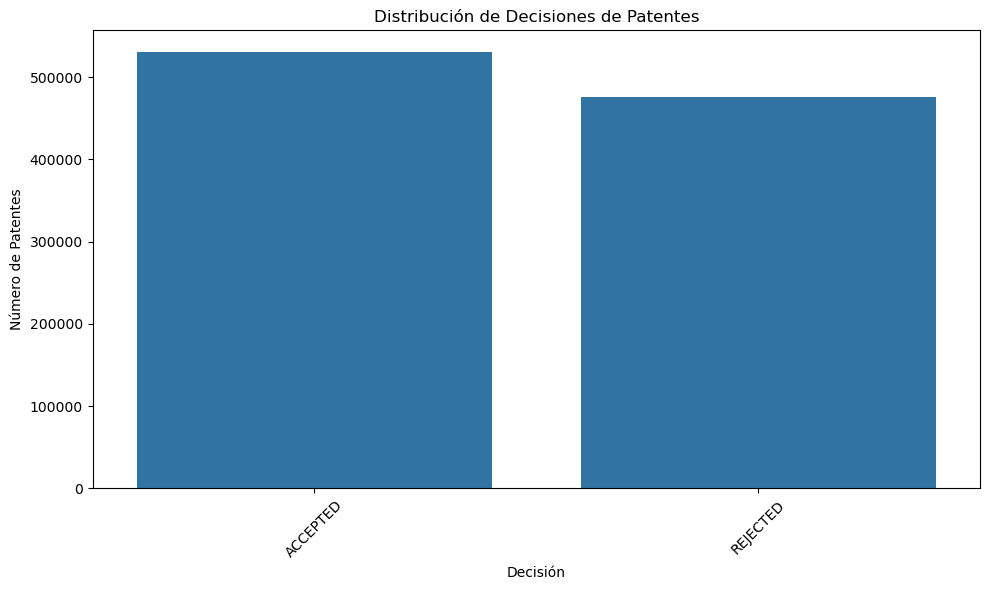

In [39]:
# diagrama de barras de la columna "value"
plt.figure(figsize=(10, 6))
sns.countplot(data=df_new_cp, x='value', order=df_new_cp['value'].value_counts().index)
plt.title('Distribución de Decisiones de Patentes')
plt.xlabel('Decisión')
plt.ylabel('Número de Patentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()